<a href="https://colab.research.google.com/github/papagorgio23/NBA_News_Spiders/blob/master/NBA%20News%20Classification%20Model/News_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2 - News Classification Model

## Load Libraries

In [0]:
## Standard 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


## Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re, string


## Prediction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

## Doc2Vec
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 

In [0]:
pd.set_option('display.max_colwidth',3000)
pd.options.display.max_rows

60

## Load Articles

In [0]:
# load data
news = pd.read_json('https://raw.githubusercontent.com/papagorgio23/NBA_News_Spiders/master/NBA_News/items.jl', lines=True)

In [0]:
news.head()

,team,url,date,title,tags,article
0,hawks,https://www.nba.com/hawks/trae-young-wins-january-nba-cares-community-assist-award,2020-02-21,[Trae Young Receives January NBA Cares Community Assist Award Presented By Kaiser Permanente | Atlanta Hawks],"[Young, Trae, Hawks, Trae, Young, trae young]","NEW YORK, Feb. 21, 2020 – Atlanta Hawks guard Trae Young has received the January NBA Cares Community Assist Award presented by Kaiser Permanente in recognition of his efforts to impact the lives of youth, families and those in need in Georgia and Oklahoma, the NBA announced today. The award recognizes a player each month who best reflects the passion that the league and NBA players share for giving back to their communities. To tip off 2020, Young helped alleviate financial hardship for Atlanta families by partnering with RIP Medical Debt to relieve insurmountable health expenses. Young donated $10,000 through the Trae Young Foundation, to help eliminate more than $1 million of medical debt for nearly 600 individuals throughout Atlanta. Additionally, Young has provided youth in his native Oklahoma with a place to develop their skills and learn the values of the game through the Trae Young Basketball Academy, and has also helped promote education, inclusion, health and wellness across Atlanta through his Trae Young Foundation. Established in 2019 with the focus of generating awareness for mental health and cyber and social media bullying, the foundation aims to positively impact children and adults facing mental health challenges through education and research. Young and his foundation are also partnering with additional health and youth-serving organizations across Atlanta. “It’s very important to me that I use my platform to make a difference and give back in any way I can,” Young said. “Working with kids across the city is not only a rewarding and inspiring experience, but something that I genuinely love to do. The city of Atlanta and everyone in it has welcomed and supported me with open arms from the very beginning and I’m honored to give back to the community every chance I get.” NBA Global Ambassador Dikembe Mutombo will present the award to Young during an oncourt ceremony before the Hawks’ home game tomorrow night against the Dallas Mavericks (7:30 p.m. ET). In addition, Kaiser Permanente and the NBA will donate $10,000 on Young’s behalf to Boys &amp; Girls Clubs of Metro Atlanta. The NBA Cares Community Assist Award presented by Kaiser Permanente recognizes an NBA player each month who best reflects the passion that the league and its players share for giving back to their communities. It honors the standard set by NBA Legend David Robinson, who improved the community piece by piece. At the end of the 2019-20 regular season, the Seasonlong NBA Cares Community Assist Award winner will be announced at the 2020 NBA Awards presented by Kia. To learn more, please visit http://www.nba.com/communityassist/."
1,hawks,https://www.nba.com/hawks/2020-jr-hawks-summer-basketball-camps-canceled-due-covid-19,2020-04-23,[2020 Jr. Hawks Summer Basketball Camps Canceled Due to COVID-19 | Atlanta Hawks],[Hawks],"As the world continues the navigate the uncertainties around the COVID-19 pandemic, we have made the decision to cancel all Jr. Hawks Summer Camps for 2020. The health and safety of your family, our staff, and community are of the highest importance. Those that have pre-paid for camp sessions will receive a full refund. To monitor the status of your refund, you can log into your Hawks Basketball Academy profile by clicking the button below, or by visiting: https://atlantahawks.leagueapps.com/login If you have not received your refund by May 10, please feel free to contact the Atlanta Hawks Basketball Academy at 404-878-3187 or hawkscamps@hawks.com. Please continue to follow the Hawks social media channels and this page for future information on how to get virtual lessons on basketball skills and drills during social distancing, along with

In [0]:
# Add Article IDs to dataframe
news = news.reset_index()
news['id'] = news['team'] + '_' + news['index'].astype(str)
news = news.drop('index', 1)

In [0]:
news.head()

,team,url,date,title,tags,article,id
0,hawks,https://www.nba.com/hawks/trae-young-wins-january-nba-cares-community-assist-award,2020-02-21,[Trae Young Receives January NBA Cares Community Assist Award Presented By Kaiser Permanente | Atlanta Hawks],"[Young, Trae, Hawks, Trae, Young, trae young]","NEW YORK, Feb. 21, 2020 – Atlanta Hawks guard Trae Young has received the January NBA Cares Community Assist Award presented by Kaiser Permanente in recognition of his efforts to impact the lives of youth, families and those in need in Georgia and Oklahoma, the NBA announced today. The award recognizes a player each month who best reflects the passion that the league and NBA players share for giving back to their communities. To tip off 2020, Young helped alleviate financial hardship for Atlanta families by partnering with RIP Medical Debt to relieve insurmountable health expenses. Young donated $10,000 through the Trae Young Foundation, to help eliminate more than $1 million of medical debt for nearly 600 individuals throughout Atlanta. Additionally, Young has provided youth in his native Oklahoma with a place to develop their skills and learn the values of the game through the Trae Young Basketball Academy, and has also helped promote education, inclusion, health and wellness across Atlanta through his Trae Young Foundation. Established in 2019 with the focus of generating awareness for mental health and cyber and social media bullying, the foundation aims to positively impact children and adults facing mental health challenges through education and research. Young and his foundation are also partnering with additional health and youth-serving organizations across Atlanta. “It’s very important to me that I use my platform to make a difference and give back in any way I can,” Young said. “Working with kids across the city is not only a rewarding and inspiring experience, but something that I genuinely love to do. The city of Atlanta and everyone in it has welcomed and supported me with open arms from the very beginning and I’m honored to give back to the community every chance I get.” NBA Global Ambassador Dikembe Mutombo will present the award to Young during an oncourt ceremony before the Hawks’ home game tomorrow night against the Dallas Mavericks (7:30 p.m. ET). In addition, Kaiser Permanente and the NBA will donate $10,000 on Young’s behalf to Boys &amp; Girls Clubs of Metro Atlanta. The NBA Cares Community Assist Award presented by Kaiser Permanente recognizes an NBA player each month who best reflects the passion that the league and its players share for giving back to their communities. It honors the standard set by NBA Legend David Robinson, who improved the community piece by piece. At the end of the 2019-20 regular season, the Seasonlong NBA Cares Community Assist Award winner will be announced at the 2020 NBA Awards presented by Kia. To learn more, please visit http://www.nba.com/communityassist/.",hawks_0
1,hawks,https://www.nba.com/hawks/2020-jr-hawks-summer-basketball-camps-canceled-due-covid-19,2020-04-23,[2020 Jr. Hawks Summer Basketball Camps Canceled Due to COVID-19 | Atlanta Hawks],[Hawks],"As the world continues the navigate the uncertainties around the COVID-19 pandemic, we have made the decision to cancel all Jr. Hawks Summer Camps for 2020. The health and safety of your family, our staff, and community are of the highest importance. Those that have pre-paid for camp sessions will receive a full refund. To monitor the status of your refund, you can log into your Hawks Basketball Academy profile by clicking the button below, or by visiting: https://atlantahawks.leagueapps.com/login If you have not received your refund by May 10, please feel free to contact the Atlanta Hawks Basketball Academy at 404-878-3187 or hawkscamps@hawks.com. Please continue to follow the Hawks social media channels and this page for future information on how to get virtual lessons on basketball skills and drills during social distancing,

In [0]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   team     768 non-null    object        
 1   url      768 non-null    object        
 2   date     734 non-null    datetime64[ns]
 3   title    768 non-null    object        
 4   tags     732 non-null    object        
 5   article  768 non-null    object        
 6   id       768 non-null    object        
dtypes: datetime64[ns](1), object(6)
memory usage: 42.1+ KB


In [0]:
news['team'].value_counts()

warriors        96
blazers         95
celtics         95
hawks           94
hornets         93
kings           64
sixers          63
pistons         12
bucks           12
pelicans        12
rockets         12
pacers          12
nuggets         12
cavaliers       12
wizards         12
timberwolves    12
suns            12
clippers        12
jazz            12
thunder         12
raptors          8
nets             3
article          1
Name: team, dtype: int64

In [0]:
news['Document_length'] = news['article'].str.len()

In [0]:
articles = news[news['team']!='article']

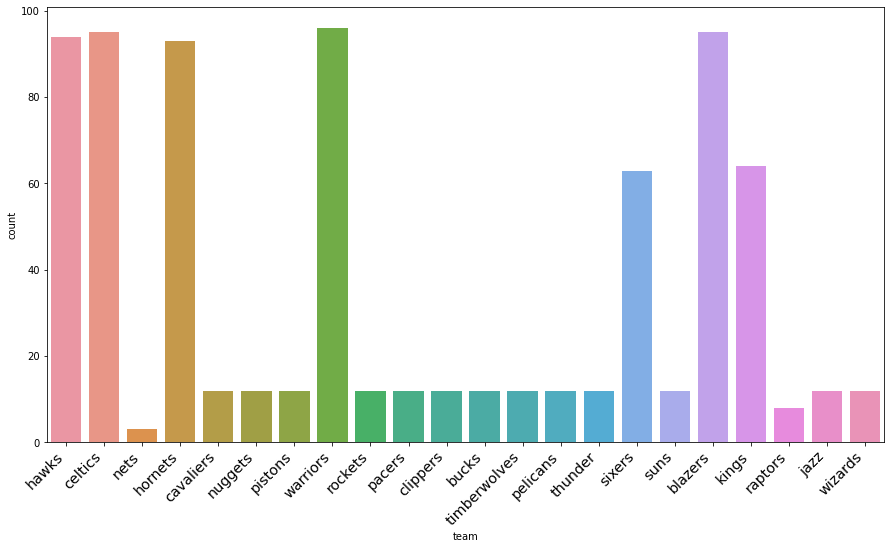

In [0]:
plt.figure(figsize = (15, 8))
ax = sns.countplot(x="team", data=articles)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
);

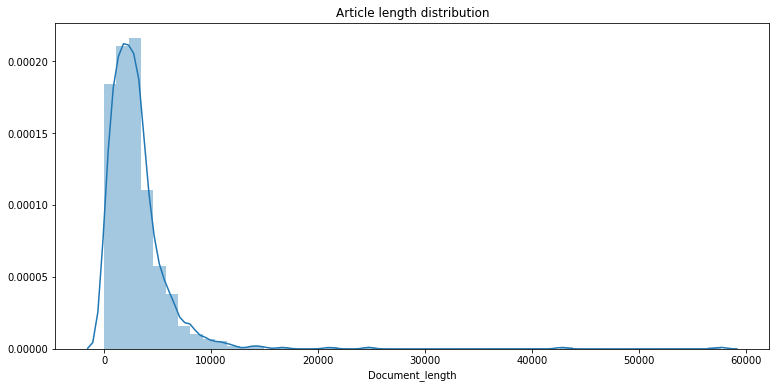

In [0]:
plt.figure(figsize=(12.8,6))
sns.distplot(articles['Document_length']).set_title('Article length distribution');

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text major ticklabel objects>)

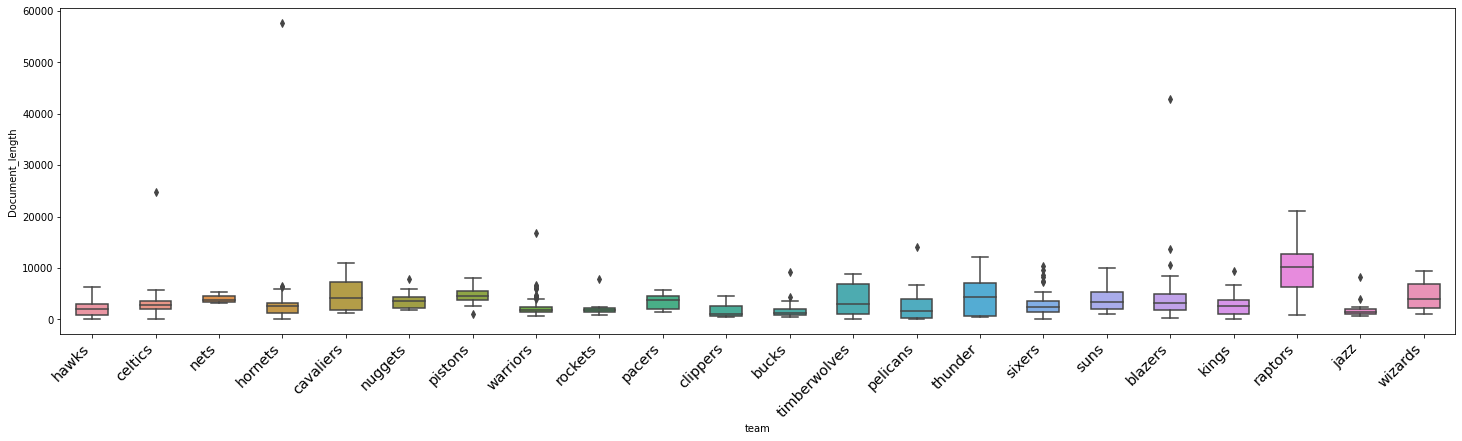

In [0]:
plt.figure(figsize=(25,6))
sns.boxplot(data=articles, x='team', y='Document_length', width=.5)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
);

## Pre-Processing

In [0]:
# unlist title 
news['title'] = [','.join(map(str, l)) for l in news['title']]

### Clean Articles

In [0]:
def parse_articles(text):
    codelist = ['\r', '\n', '\t'] 
    text = text.lower()
    text = re.sub(r"[^\w\d'\s]+", '', text)  # no punct except single quote 
    text = re.sub(r'[^\x00-\x7f]',r'', text)  # no non-ASCII strings    
    text = re.sub(r'http\S+',r'', text)  # remove links
    text = re.sub('\s+', ' ', text)  # replace multiple spaces with one space 
    for code in codelist:
        text = re.sub(code, ' ', text)  # get rid of escape codes  
    text = text.split("recieve warriors insider")[0] # the warriors website had an extra paragraph in every article that was an add
    text = text.strip()
    return text


In [0]:
# Parse each article
news['article_1'] = news['article'].apply(parse_articles)

### Remove Stopwords

In [0]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# text parsing for words within entire document string
# splits the document string into words/tokens
# parses the words and then recreates a document string
# returns list of parsed words/tokens and parsed document string
def parse_words(text): 
    # split document into individual words
    tokens = text.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out tokens that are one or two characters long
    tokens = [word for word in tokens if len(word) > 2]
    # filter out tokens that are more than twenty characters long
    tokens = [word for word in tokens if len(word) < 21]
    # filter out stop words if requested
    tokens = [w for w in tokens if not w in stop_words]         
    # recreate the document string from parsed words
    text = ''
    for token in tokens:
        text = text + ' ' + token
    return text 

In [0]:
# Parse words remove stop words
news['article_2'] = news['article_1'].apply(parse_words)

### Stemming

In [0]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
------------------------------------------------------------
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [0]:
nrows = len(news)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = news.loc[row]['article_2']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [0]:
news['article_3'] = lemmatized_text_list

In [0]:
news.head()

,team,url,date,title,tags,article,id,Document_length,article_1,article_2,article_3
0,hawks,https://www.nba.com/hawks/trae-young-wins-january-nba-cares-community-assist-award,2020-02-21,Trae Young Receives January NBA Cares Community Assist Award Presented By Kaiser Permanente | Atlanta Hawks,"[Young, Trae, Hawks, Trae, Young, trae young]","NEW YORK, Feb. 21, 2020 – Atlanta Hawks guard Trae Young has received the January NBA Cares Community Assist Award presented by Kaiser Permanente in recognition of his efforts to impact the lives of youth, families and those in need in Georgia and Oklahoma, the NBA announced today. The award recognizes a player each month who best reflects the passion that the league and NBA players share for giving back to their communities. To tip off 2020, Young helped alleviate financial hardship for Atlanta families by partnering with RIP Medical Debt to relieve insurmountable health expenses. Young donated $10,000 through the Trae Young Foundation, to help eliminate more than $1 million of medical debt for nearly 600 individuals throughout Atlanta. Additionally, Young has provided youth in his native Oklahoma with a place to develop their skills and learn the values of the game through the Trae Young Basketball Academy, and has also helped promote education, inclusion, health and wellness across Atlanta through his Trae Young Foundation. Established in 2019 with the focus of generating awareness for mental health and cyber and social media bullying, the foundation aims to positively impact children and adults facing mental health challenges through education and research. Young and his foundation are also partnering with additional health and youth-serving organizations across Atlanta. “It’s very important to me that I use my platform to make a difference and give back in any way I can,” Young said. “Working with kids across the city is not only a rewarding and inspiring experience, but something that I genuinely love to do. The city of Atlanta and everyone in it has welcomed and supported me with open arms from the very beginning and I’m honored to give back to the community every chance I get.” NBA Global Ambassador Dikembe Mutombo will present the award to Young during an oncourt ceremony before the Hawks’ home game tomorrow night against the Dallas Mavericks (7:30 p.m. ET). In addition, Kaiser Permanente and the NBA will donate $10,000 on Young’s behalf to Boys &amp; Girls Clubs of Metro Atlanta. The NBA Cares Community Assist Award presented by Kaiser Permanente recognizes an NBA player each month who best reflects the passion that the league and its players share for giving back to their communities. It honors the standard set by NBA Legend David Robinson, who improved the community piece by piece. At the end of the 2019-20 regular season, the Seasonlong NBA Cares Community Assist Award winner will be announced at the 2020 NBA Awards presented by Kia. To learn more, please visit http://www.nba.com/communityassist/.",hawks_0,2670,newyork feb 21 2020atlanta hawks guard trae young has received the january nba cares community assist award presented by kaiser permanente in recognition of his efforts to impact the lives of youth families and those in need in georgia and oklahoma the nba announced todaythe award recognizes a player each month who best reflects the passion that the league and nba players share for giving back to their communities to tip off 2020 young helped alleviate financial hardship for atlanta families by partnering with rip medical debt to relieve insurmountable health expenses young donated 10000 through the trae young foundation to help eliminate more than 1 million of medical debt for nearly 600 individuals throughout atlanta additionally young has provided youth in his native oklahoma with a place to develop their skills and learn the values of the game through the trae young basketball academy and has also helped promote education inclusion health and wellness across atlanta t

# Dependent Variable

In [0]:
# Relevant = 1
# Irrelevant = 0

# Initialize column
news['Relevant'] = "Undefined"

## Podcasts are pointless
news.loc[news['title'].str.contains('PODCAST'), 'Relevant'] = 'Irrelevant'


### FOR SURE Relevant
# Team Updates
news.loc[news['title'].str.contains('Update'), 'Relevant'] = 'Relevant'
news.loc[news['id'] == 'hawks_58', 'Relevant'] = 'Relevant'  # suspended

# Injuries
news.loc[news['title'].str.contains('Injury'), 'Relevant'] = 'Relevant'
news.loc[news['title'].str.contains('injury'), 'Relevant'] = 'Relevant'
news.loc[news['article_1'].str.contains('injury'), 'Relevant'] = 'Relevant'
news.loc[news['article_1'].str.contains('injured'), 'Relevant'] = 'Relevant'

# Trades
news.loc[news['article_1'].str.contains('trade'), 'Relevant'] = 'Relevant'
news.loc[news['title'].str.contains('Waive'), 'Relevant'] = 'Relevant'
news.loc[news['title'].str.contains('Recall'), 'Relevant'] = 'Relevant'
news.loc[news['title'].str.contains('Legends'), 'Relevant'] = 'Relevant'
news.loc[news['title'].str.contains('Sign'), 'Relevant'] = 'Relevant'
news.loc[news['title'].str.contains('Assign'), 'Relevant'] = 'Relevant'
news.loc[news['title'].str.contains('Acquire'), 'Relevant'] = 'Relevant'
news.loc[news['title'].str.contains('Exchange'), 'Relevant'] = 'Relevant'

# Game Analysis
news.loc[news['article_1'].str.contains('postgame'), 'Relevant'] = 'Relevant'
news.loc[news['article_1'].str.contains('postgame'), 'Relevant'] = 'Relevant'
news.loc[news['article_1'].str.contains('pregame'), 'Relevant'] = 'Relevant'
news.loc[news['title'].str.contains('Pregame'), 'Relevant'] = 'Relevant'
news.loc[news['title'].str.contains('Game'), 'Relevant'] = 'Relevant'
news.loc[news['article_3'].str.contains('season series'), 'Relevant'] = 'Relevant'
news.loc[news['article_3'].str.contains('point rebound'), 'Relevant'] = 'Relevant'
news.loc[news['article_3'].str.contains('per game'), 'Relevant'] = 'Relevant'





### FOR SURE Irrelevant
news.loc[news['date'] >= '2020-03-12', 'Relevant'] = 'Irrelevant'  # NBA SHUT DOWN On this date so anything after will be not be about the games
# Virus
news.loc[news['title'].str.contains('COVID'), 'Relevant'] = 'Irrelevant'
news.loc[news['article_1'].str.contains('covid'), 'Relevant'] = 'Irrelevant'
news.loc[news['article_1'].str.contains('coronavirus'), 'Relevant'] = 'Irrelevant'
news.loc[news['article_3'].str.contains('coronavirus'), 'Relevant'] = 'Irrelevant'
news.loc[news['article_1'].str.contains('wash your hands'), 'Relevant'] = 'Irrelevant'
news.loc[news['id'] == 'blazers_595', 'Relevant'] = 'Irrelevant'

# E-Sports
news.loc[news['article_1'].str.contains('2k20'), 'Relevant'] = 'Irrelevant'
news.loc[news['article_1'].str.contains('nba 2k'), 'Relevant'] = 'Irrelevant'
news.loc[news['article_1'].str.contains('simulation'), 'Relevant'] = 'Irrelevant'

# All-Star Weekend
news.loc[news['article_1'].str.contains('allstar weekend'), 'Relevant'] = 'Irrelevant'
news.loc[news['article_1'].str.contains('allstar game'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('USA Basketball'), 'Relevant'] = 'Irrelevant'


# Misc
news.loc[news['article_1'].str.contains('professional wrestling'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Postgame'), 'Relevant'] = 'Irrelevant' # 7 articles that are actually just videos.
news.loc[news['title'].str.contains('Clipboard'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('History'), 'Relevant'] = 'Irrelevant'
news.loc[news['id'] == 'kings_723', 'Relevant'] = 'Irrelevant'
news.loc[news['id'] == 'hawks_57', 'Relevant'] = 'Irrelevant'   # Deep dive player background
news.loc[news['id'] == 'hawks_60', 'Relevant'] = 'Irrelevant' 
news.loc[news['id'] == 'hawks_61', 'Relevant'] = 'Irrelevant'  # Angola Player Backstory
news.loc[news['id'] == 'hawks_81', 'Relevant'] = 'Irrelevant'  # New Hires
news.loc[news['id'] == 'hawks_84', 'Relevant'] = 'Irrelevant'  # ESPN award
news.loc[news['id'] == 'hawks_97', 'Relevant'] = 'Irrelevant' 
news.loc[news['id'] == 'kings_739', 'Relevant'] = 'Irrelevant' 
news.loc[news['title'].str.contains('Conference Coach'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Kobe'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('DJ Booth'), 'Relevant'] = 'Irrelevant'

# Marketing
news.loc[news['title'].str.contains('BOBBLEHEADS'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Taco Bell'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('State Farm'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Spades Tournament'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Nike City'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('TikTok'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('BUDWEISER'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Royalty Pass'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Contest'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Intel Launch'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('IoT-Powered'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('NBA FIT'), 'Relevant'] = 'Irrelevant'
news.loc[news['id'] == 'hawks_30', 'Relevant'] = 'Irrelevant' 


# foreign characters 
news.loc[news['id'] == 'kings_741', 'Relevant'] = 'Irrelevant'  
news.loc[news['id'] == 'kings_742', 'Relevant'] = 'Irrelevant'
news.loc[news['id'] == 'kings_764', 'Relevant'] = 'Irrelevant' 
news.loc[news['article_3'].str.contains('los sixers'), 'Relevant'] = 'Irrelevant'

# community
news.loc[news['id'] == 'hawks_7', 'Relevant'] = 'Irrelevant' 
news.loc[news['id'] == 'hawks_12', 'Relevant'] = 'Irrelevant' 
news.loc[news['title'].str.contains('Clinic'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Communities'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Yellow Ribbon'), 'Relevant'] = 'Irrelevant'
news.loc[news['article_1'].str.contains('lgbtq community'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('River-Rafting'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Filipino Roots'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Celebrating Women'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Peaceful Warriors'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('PRIDE NIGHT'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Dreamville'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Wrongful Convictions'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('Education Grant'), 'Relevant'] = 'Irrelevant'
news.loc[news['title'].str.contains('NBA Cares'), 'Relevant'] = 'Irrelevant'


# Remaining Game Related
news.loc[news['Relevant'] == 'Undefined', 'Relevant'] = 'Relevant' 



In [0]:
news['Relevant'].value_counts()

Irrelevant    493
Relevant      275
Name: Relevant, dtype: int64

## Join All Articles Together

In [0]:
all_news = news['article_3'].str.strip().values.tolist()

In [0]:
def concatenate_list_data(list):
	    result= ''
	    for element in list:
	        result += str(element) + " "
	    return result

In [0]:
all_news_str = concatenate_list_data(all_news)

## Tokenize Words

In [0]:
import string

tokens = all_news_str.split()
# remove punctuation from each token
table = str.maketrans('', '', string.punctuation)
tokens = [w.translate(table) for w in tokens]
# remove remaining tokens that are not alphabetic
tokens = [word for word in tokens if word.isalpha()]

In [0]:
print(tokens[:80])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

['newyork', 'feb', 'hawk', 'guard', 'trae', 'young', 'receive', 'january', 'nba', 'care', 'community', 'assist', 'award', 'present', 'kaiser', 'permanente', 'recognition', 'efforts', 'impact', 'live', 'youth', 'families', 'need', 'georgia', 'oklahoma', 'nba', 'announce', 'todaythe', 'award', 'recognize', 'player', 'month', 'best', 'reflect', 'passion', 'league', 'nba', 'players', 'share', 'give', 'back', 'communities', 'tip', 'young', 'help', 'alleviate', 'financial', 'hardship', 'atlanta', 'families', 'partner', 'rip', 'medical', 'debt', 'relieve', 'insurmountable', 'health', 'expense', 'young', 'donate', 'trae', 'young', 'foundation', 'help', 'eliminate', 'million', 'medical', 'debt', 'nearly', 'individuals', 'throughout', 'atlanta', 'additionally', 'young', 'provide', 'youth', 'native', 'oklahoma', 'place', 'develop']
Total Tokens: 212918
Unique Tokens: 14034


## Word Frequency

In [0]:
# Python program to find the k most frequent words 
# from data set 
from collections import Counter 

# Pass the split_it list to instance of Counter class. 
Counter = Counter(tokens) 

# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = Counter.most_common(25) 

print(most_occur) 

[('game', 3423), ('point', 2143), ('season', 1748), ('team', 1626), ('get', 1566), ('play', 1536), ('nba', 1527), ('say', 1273), ('time', 1184), ('make', 1131), ('go', 1078), ('first', 1073), ('one', 1042), ('like', 923), ('two', 877), ('win', 877), ('shoot', 872), ('rebound', 854), ('come', 800), ('take', 748), ('warriors', 747), ('score', 723), ('three', 718), ('assist', 707), ('back', 700)]


In [0]:
word_feq = pd.DataFrame.from_dict(Counter, orient='index').reset_index()
word_feq.columns = ['Word', 'Frequency']
word_feq = word_feq.sort_values(by='Frequency', ascending=False)

In [0]:
word_feq.head(30)

,Word,Frequency
68,game,3423
711,point,2143
150,season,1748
392,team,1626
121,get,1566
695,play,1536
8,nba,1527
102,say,1273
429,time,1184
99,make,1131


### Bi-Grams Frequency

In [0]:
import nltk
#words = nltk.word_tokenize(my_text)
my_bigrams = nltk.bigrams(tokens)
my_trigrams = nltk.trigrams(tokens)

In [0]:
# Python program to find the k most frequent words 
# from data set 
from collections import Counter 

# Pass the split_it list to instance of Counter class. 
BiCounter = Counter(my_bigrams) 
TriCounter = Counter(my_trigrams) 

# most_common() produces k frequently encountered 
# input values and their respective counts. 
bimost_occur = BiCounter.most_common(25) 
trimost_occur = TriCounter.most_common(25) 

print("Most Frequent Bi-Grams: ", bimost_occur) 
print("Most Frequent Bi-Grams: ", trimost_occur) 

Most Frequent Bi-Grams:  [(('trail', 'blazers'), 547), (('point', 'rebound'), 332), (('average', 'point'), 310), (('per', 'game'), 206), (('rebound', 'assist'), 199), (('head', 'coach'), 167), (('score', 'point'), 160), (('damian', 'lillard'), 156), (('atlanta', 'hawk'), 150), (('nba', 'finals'), 128), (('point', 'shoot'), 126), (('new', 'orleans'), 123), (('read', 'full'), 121), (('full', 'story'), 118), (('los', 'angeles'), 117), (('regular', 'season'), 112), (('free', 'throw'), 109), (('nbc', 'sport'), 106), (('point', 'guard'), 105), (('stephen', 'curry'), 105), (('state', 'farm'), 104), (('game', 'season'), 104), (('sacramento', 'kings'), 103), (('nba', 'season'), 103), (('golden', 'state'), 99)]
Most Frequent Bi-Grams:  [(('average', 'point', 'rebound'), 183), (('point', 'rebound', 'assist'), 162), (('read', 'full', 'story'), 118), (('portland', 'trail', 'blazers'), 89), (('point', 'per', 'game'), 61), (('score', 'least', 'point'), 61), (('state', 'farm', 'arena'), 59), (('reboun

In [0]:
bigram_feq = pd.DataFrame.from_dict(BiCounter, orient='index').reset_index()
trigram_feq = pd.DataFrame.from_dict(TriCounter, orient='index').reset_index()
bigram_feq.columns = ['Bi-Gram', 'Frequency']
trigram_feq.columns = ['Tri-Gram', 'Frequency']
bigram_feq = bigram_feq.sort_values(by='Frequency', ascending=False)
trigram_feq = trigram_feq.sort_values(by='Frequency', ascending=False)

In [0]:
bigram_feq.head(30)

,Bi-Gram,Frequency
2177,"(trail, blazers)",547
1857,"(point, rebound)",332
1856,"(average, point)",310
2200,"(per, game)",206
1858,"(rebound, assist)",199
593,"(head, coach)",167
1889,"(score, point)",160
2563,"(damian, lillard)",156
258,"(atlanta, hawk)",150
389,"(nba, finals)",128


In [0]:
bigram_feq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135790 entries, 2177 to 135789
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Bi-Gram    135790 non-null  object
 1   Frequency  135790 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


### Tri-Grams

In [0]:
trigram_feq.head(30)

,Tri-Gram,Frequency
2005,"(average, point, rebound)",183
2006,"(point, rebound, assist)",162
78294,"(read, full, story)",118
2361,"(portland, trail, blazers)",89
18408,"(score, least, point)",61
2968,"(point, per, game)",61
1047,"(state, farm, arena)",59
2386,"(minutes, per, game)",51
2120,"(rebound, assist, steal)",51
3435,"(golden, state, warriors)",47


In [0]:
trigram_feq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189189 entries, 2005 to 189188
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Tri-Gram   189189 non-null  object
 1   Frequency  189189 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


## Prediction Models

### Split Data

In [0]:
X_train, X_test, y_train, y_test = train_test_split(news['article_3'], 
                                                    news['Relevant'], 
                                                    test_size=0.30, 
                                                    random_state=8)

In [0]:
X = news['article_3']
X.shape

(768,)

In [0]:
print(X_train.shape)
print(y_train.shape)

(537,)
(537,)


In [0]:
print(X_test.shape)
print(y_test.shape)

(231,)
(231,)


### Word Freq in Training Set

In [0]:
train_news = X_train.str.strip().values.tolist()
train_news_str = concatenate_list_data(train_news)

In [0]:
import string

train_tokens = train_news_str.split()
# remove punctuation from each token
table = str.maketrans('', '', string.punctuation)
train_tokens = [w.translate(table) for w in train_tokens]
# remove remaining tokens that are not alphabetic
train_tokens = [word for word in train_tokens if word.isalpha()]

In [0]:
print(train_tokens[:80])
print('Total Tokens: %d' % len(train_tokens))
print('Unique Tokens: %d' % len(set(train_tokens)))

['miss', 'roughly', 'first', 'month', 'season', 'ian', 'mahinmi', 'return', 'injury', 'bolster', 'alreadydeep', 'wizards', 'frontcourt', 'size', 'strength', 'season', 'mahinmis', 'greatest', 'impact', 'come', 'defensive', 'end', 'highlight', 'game', 'multiple', 'block', 'though', 'put', 'best', 'allaround', 'performances', 'career', 'offensive', 'end', 'best', 'game', 'season', 'define', 'efficiency', 'include', 'four', 'game', 'season', 'field', 'goal', 'percentage', 'sevenplus', 'attempt', 'closer', 'look', 'mahinmis', 'three', 'best', 'overall', 'performances', 'season', 'january', 'utah', 'play', 'rudy', 'gobert', 'one', 'league', 'decorate', 'defensive', 'big', 'men', 'generation', 'mahinmi', 'tweak', 'game', 'put', 'one', 'balance', 'performances', 'career', 'score', 'point', 'field', 'contributions']
Total Tokens: 145252
Unique Tokens: 11764


In [0]:
# Python program to find the k most frequent words 
# from data set 
from collections import Counter 

# Pass the split_it list to instance of Counter class. 
Counter = Counter(train_tokens) 

# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = Counter.most_common(25) 

print(most_occur) 

[('game', 2343), ('point', 1533), ('season', 1188), ('team', 1121), ('nba', 1064), ('play', 982), ('get', 975), ('say', 856), ('time', 782), ('make', 753), ('first', 723), ('one', 722), ('go', 679), ('win', 606), ('two', 596), ('rebound', 587), ('shoot', 582), ('warriors', 574), ('like', 537), ('come', 527), ('score', 525), ('assist', 496), ('three', 493), ('take', 487), ('lead', 484)]


In [0]:
train_word_feq = pd.DataFrame.from_dict(Counter, orient='index').reset_index()
train_word_feq.columns = ['Word', 'Frequency']
train_word_feq = train_word_feq.sort_values(by='Frequency', ascending=False)

In [0]:
train_word_feq.head(30)

,Word,Frequency
22,game,2343
59,point,1533
4,season,1188
311,team,1121
449,nba,1064
47,play,982
181,get,975
97,say,856
150,time,782
184,make,753


In [0]:
train_word_feq[train_word_feq['Frequency']>1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6625 entries, 22 to 5512
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Word       6625 non-null   object
 1   Frequency  6625 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 155.3+ KB


6,625 words in the training dataset with more than 1 occurrence 

In [0]:
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 1500

In [0]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X).toarray()
print(features_train.shape)

(768, 1500)


In [0]:
terms = tfidf.get_feature_names()

In [0]:
from sklearn.cluster import KMeans

num_clusters = 2

km = KMeans(n_clusters=num_clusters)

%time km.fit(features_train)

clusters = km.labels_.tolist()

CPU times: user 644 ms, sys: 489 ms, total: 1.13 s
Wall time: 590 ms


In [0]:
from scipy.cluster.hierarchy import dendrogram, ward, linkage

In [0]:
tfidfT = pd.DataFrame(features_train)

In [0]:
tfidfT = tfidfT.T

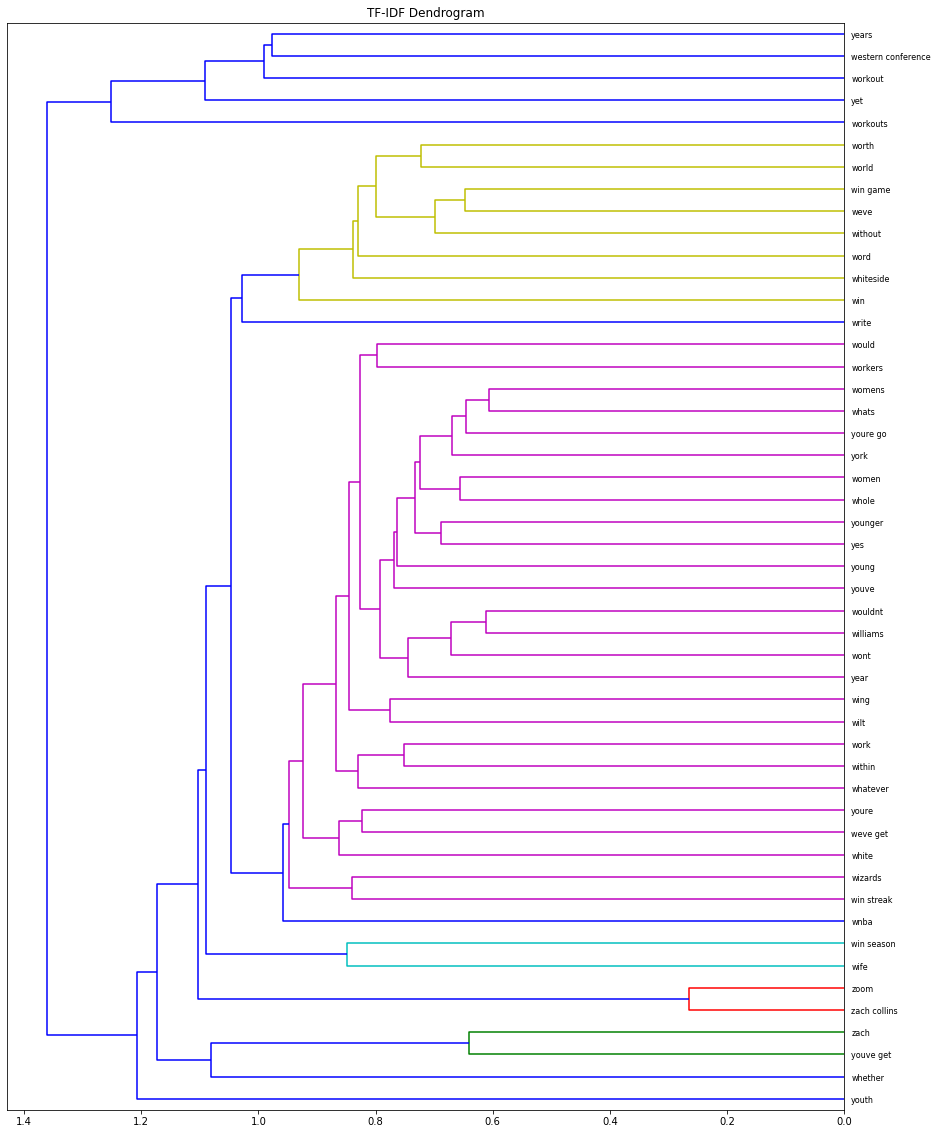

In [0]:
plt.figure(figsize=(15, 20))
plt.title("TF-IDF Dendrogram")
dend = dendrogram(
    linkage(tfidfT.iloc[1:50, :].values, method="ward"),
    orientation="left",
    labels=terms,
);
#plt.savefig("imgs/tfidf_dendrogram.png")

# Modeling Approach

## Global Parameters

In [0]:
### SET PARAMETERS
MAX_NGRAM_LENGTH = 2
SET_RANDOM = 1234


## Approach 1: Analyst Judgment

### Vector Size (K) = 50

In [0]:
##############################
### Count Vectorization
##############################

# Start Timer
start = datetime.datetime.now()

count_vectorizer = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 50)
count_vectors = count_vectorizer.fit_transform(X_train)
print('\ncount vectorization. . .')
print('\nTraining count_vectors_training.shape:', count_vectors.shape)

# Apply the same vectorizer to the test data
# Notice how we use count_vectorizer.transform, NOT count_vectorizer.fit_transform
count_vectors_test = count_vectorizer.transform(X_test)
print('\nTest count_vectors_test.shape:', count_vectors_test.shape)
count_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
count_clf.fit(count_vectors, y_train)
count_pred = count_clf.predict(count_vectors_test)  # evaluate on test set
print('\nAnalyst Judgment 50\nRandom Forest F1 classification performance in test set:',
    round(metrics.f1_score(y_test, count_pred, average='macro'), 3))

end = datetime.datetime.now()
aj50_time_diff = end-start
print()
print()
print('Time to train = {}'.format(aj50_time_diff))


count vectorization. . .

Training count_vectors_training.shape: (537, 50)

Test count_vectors_test.shape: (231, 50)

Analyst Judgment 50
Random Forest F1 classification performance in test set: 0.835


Time to train = 0:00:00.700182


### Vector Size (K) = 150

In [0]:
##############################
### Count Vectorization
##############################

# Start Timer
start = datetime.datetime.now()

count_vectorizer = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 150)
count_vectors = count_vectorizer.fit_transform(X_train)
print('\ncount vectorization. . .')
print('\nTraining count_vectors_training.shape:', count_vectors.shape)

# Apply the same vectorizer to the test data
# Notice how we use count_vectorizer.transform, NOT count_vectorizer.fit_transform
count_vectors_test = count_vectorizer.transform(X_test)
print('\nTest count_vectors_test.shape:', count_vectors_test.shape)
count_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
count_clf.fit(count_vectors, y_train)
count_pred = count_clf.predict(count_vectors_test)  # evaluate on test set
print('\nAnalyst Judgment 150\nRandom Forest F1 classification performance in test set:',
    round(metrics.f1_score(y_test, count_pred, average='macro'), 3))

end = datetime.datetime.now()
aj150_time_diff = end-start
print()
print()
print('Time to train = {}'.format(aj150_time_diff))


count vectorization. . .

Training count_vectors_training.shape: (537, 150)

Test count_vectors_test.shape: (231, 150)

Analyst Judgment 150
Random Forest F1 classification performance in test set: 0.844


Time to train = 0:00:00.739362


### Vector Size (K) = 300

In [0]:
##############################
### Count Vectorization
##############################

# Start Timer
start = datetime.datetime.now()

count_vectorizer = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 300)
count_vectors = count_vectorizer.fit_transform(X_train)
print('\ncount vectorization. . .')
print('\nTraining count_vectors_training.shape:', count_vectors.shape)

# Apply the same vectorizer to the test data
# Notice how we use count_vectorizer.transform, NOT count_vectorizer.fit_transform
count_vectors_test = count_vectorizer.transform(X_test)
print('\nTest count_vectors_test.shape:', count_vectors_test.shape)
count_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
count_clf.fit(count_vectors, y_train)
count_pred = count_clf.predict(count_vectors_test)  # evaluate on test set
print('\nAnalyst Judgment 300\nRandom Forest F1 classification performance in test set:',
    round(metrics.f1_score(y_test, count_pred, average='macro'), 3))

end = datetime.datetime.now()
aj300_time_diff = end-start
print()
print()
print('Time to train = {}'.format(aj300_time_diff))


count vectorization. . .

Training count_vectors_training.shape: (537, 300)

Test count_vectors_test.shape: (231, 300)

Analyst Judgment 300
Random Forest F1 classification performance in test set: 0.82


Time to train = 0:00:00.731273


## Approach 2: TF-IDF

### Vector Size (K) = 50

In [0]:
##############################
### TF-IDF Vectorization
##############################

# Start Timer
start = datetime.datetime.now()

# initalize TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 50)
tfidf_vectors = tfidf_vectorizer.fit_transform(X_train)
print('\nTFIDF vectorization. . .')
print('\nTraining tfidf_vectors_training.shape:', tfidf_vectors.shape)

# Apply the same vectorizer to the test data
# Notice how we use tfidf_vectorizer.transform, NOT tfidf_vectorizer.fit_transform
tfidf_vectors_test = tfidf_vectorizer.transform(X_test)
print('\nTest tfidf_vectors_test.shape:', tfidf_vectors_test.shape)
tfidf_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
tfidf_clf.fit(tfidf_vectors, y_train)
tfidf_pred = tfidf_clf.predict(tfidf_vectors_test)  # evaluate on test set
print('\nTF-IDF 50\nRandom Forest F1 classification performance in test set:',
    round(metrics.f1_score(y_test, tfidf_pred, average='macro'), 3))

end = datetime.datetime.now()
tf50_time_diff = end-start
print()
print()
print('Time to train = {}'.format(tf50_time_diff))


TFIDF vectorization. . .

Training tfidf_vectors_training.shape: (537, 50)

Test tfidf_vectors_test.shape: (231, 50)

TF-IDF 50
Random Forest F1 classification performance in test set: 0.838


Time to train = 0:00:00.722591


### Vector Size (K) = 150

In [0]:
##############################
### TF-IDF Vectorization
##############################
# Start Timer
start = datetime.datetime.now()

# initalize TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 150)
tfidf_vectors = tfidf_vectorizer.fit_transform(X_train)
print('\nTFIDF vectorization. . .')
print('\nTraining tfidf_vectors_training.shape:', tfidf_vectors.shape)

# Apply the same vectorizer to the test data
# Notice how we use tfidf_vectorizer.transform, NOT tfidf_vectorizer.fit_transform
tfidf_vectors_test = tfidf_vectorizer.transform(X_test)
print('\nTest tfidf_vectors_test.shape:', tfidf_vectors_test.shape)
tfidf_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
tfidf_clf.fit(tfidf_vectors, y_train)
tfidf_pred = tfidf_clf.predict(tfidf_vectors_test)  # evaluate on test set
print('\nTF-IDF 150\nRandom Forest F1 classification performance in test set:',
    round(metrics.f1_score(y_test, tfidf_pred, average='macro'), 3))

end = datetime.datetime.now()
tf150_time_diff = end-start
print()
print()
print('Time to train = {}'.format(tf150_time_diff))


TFIDF vectorization. . .

Training tfidf_vectors_training.shape: (537, 150)

Test tfidf_vectors_test.shape: (231, 150)

TF-IDF 150
Random Forest F1 classification performance in test set: 0.822


Time to train = 0:00:00.739246


### Vector Size (K) = 300

In [0]:
##############################
### TF-IDF Vectorization
##############################
# Start Timer
start = datetime.datetime.now()

# initalize TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = 300)
tfidf_vectors = tfidf_vectorizer.fit_transform(X_train)
print('\nTFIDF vectorization. . .')
print('\nTraining tfidf_vectors_training.shape:', tfidf_vectors.shape)

# Apply the same vectorizer to the test data
# Notice how we use tfidf_vectorizer.transform, NOT tfidf_vectorizer.fit_transform
tfidf_vectors_test = tfidf_vectorizer.transform(X_test)
print('\nTest tfidf_vectors_test.shape:', tfidf_vectors_test.shape)
tfidf_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
tfidf_clf.fit(tfidf_vectors, y_train)
tfidf_pred = tfidf_clf.predict(tfidf_vectors_test)  # evaluate on test set
print('\nTF-IDF 300\nRandom Forest F1 classification performance in test set:',
    round(metrics.f1_score(y_test, tfidf_pred, average='macro'), 3))

end = datetime.datetime.now()
tf300_time_diff = end-start
print()
print()
print('Time to train = {}'.format(tf300_time_diff))


TFIDF vectorization. . .

Training tfidf_vectors_training.shape: (537, 300)

Test tfidf_vectors_test.shape: (231, 300)

TF-IDF 300
Random Forest F1 classification performance in test set: 0.818


Time to train = 0:00:00.750846


## Approach 3: Doc2Vec

### Additional Data Prep

In [0]:
X_train.str.strip().values.tolist()

In [0]:
X_train_list = X_train.str.strip().values.tolist()
X_test_list = X_test.str.strip().values.tolist()

In [0]:
# text parsing function for entire document string
def parse_doc(text):
    text = text.lower()
    text = re.sub(r'&(.)+', "", text)  # no & references  
    text = re.sub(r'pct', 'percent', text)  # replace pct abreviation  
    text = re.sub(r"[^\w\d'\s]+", '', text)  # no punct except single quote 
    text = re.sub(r'[^\x00-\x7f]',r'', text)  # no non-ASCII strings    
    if text.isdigit(): text = ""  # omit words that are all digits    
    for code in codelist:
        text = re.sub(code, ' ', text)  # get rid of escape codes  
    # replace multiple spaces with one space
    text = re.sub('\s+', ' ', text)        
    return text

In [0]:
# text parsing for words within entire document string
# splits the document string into words/tokens
# parses the words and then recreates a document string
# returns list of parsed words/tokens and parsed document string
def parse_words(text): 
    # split document into individual words
    tokens=text.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out tokens that are one or two characters long
    tokens = [word for word in tokens if len(word) > 2]
    # filter out tokens that are more than twenty characters long
    tokens = [word for word in tokens if len(word) < 21]
    # filter out stop words if requested
    if DROP_STOPWORDS:
        tokens = [w for w in tokens if not w in stoplist]         
    # perform word stemming if requested
    if STEMMING:
        ps = PorterStemmer()
        tokens = [ps.stem(word) for word in tokens]
    # recreate the document string from parsed words
    text = ''
    for token in tokens:
        text = text + ' ' + token
    return tokens, text 

In [0]:

##############################
### Prepare Training Data 
##############################
train_tokens = []  # list of token lists for gensim Doc2Vec
train_text = [] # list of document strings for sklearn TF-IDF
labels = []  # use filenames as labels
for doc in X_train_list:
    text_string = doc
    # parse the entire document string
    text_string = parse_doc(text_string)
    # parse words one at a time in document string
    tokens, text_string = parse_words(text_string)
    train_tokens.append(tokens)
    train_text.append(text_string)
print('\nNumber of training documents:',
	len(train_text))	
print('\nFirst item after text preprocessing, train_text[0]\n', 
	train_text[0])
print('\nNumber of training token lists:',
	len(train_tokens))	
print('\nFirst list of tokens after text preprocessing, train_tokens[0]\n', 
	train_tokens[0])

##############################
### Prepare Test Data 
##############################
test_tokens = []  # list of token lists for gensim Doc2Vec
test_text = [] # list of document strings for sklearn TF-IDF
labels = []  # use filenames as labels
for doc in X_test_list:
    text_string = doc
    # parse the entire document string
    text_string = parse_doc(text_string)
    # parse words one at a time in document string
    tokens, text_string = parse_words(text_string)
    test_tokens.append(tokens)
    test_text.append(text_string)
print('\nNumber of testing documents:',
	len(test_text))	
print('\nFirst item after text preprocessing, test_text[0]\n', 
	test_text[0])
print('\nNumber of testing token lists:',
	len(test_tokens))	
print('\nFirst list of tokens after text preprocessing, test_tokens[0]\n', 
	test_tokens[0])


Number of training documents: 537

First item after text preprocessing, train_text[0]
  miss roughly first month season ian mahinmi return injury bolster alreadydeep wizards frontcourt size strength season mahinmis greatest impact come defensive end highlight game multiple block though put best allaround performances career offensive end best game season define efficiency include four game season field goal percentage sevenplus attempt closer look mahinmis three best overall performances season january utah play rudy gobert one league decorate defensive big men generation mahinmi tweak game put one balance performances career score point field contributions span column box score score first half total nine point second half highlight five careerhigh seven assist game season four dim mahinmi also grab six rebound record pair block january detroit wizards midafternoon martin luther king day win pistons mahinmi tally second performance career second game season shoot least field one four

### Vector Size (K) = 50

In [0]:

###########################################
### Doc2Vec Vectorization (50 dimensions)
###########################################

# Start Timer
start = datetime.datetime.now()


print('\nBegin Doc2Vec Work')
cores = multiprocessing.cpu_count()
print("\nNumber of processor cores:", cores)

train_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_tokens)]

# Instantiate a Doc2Vec model with a vector size with 50 words 
print("\nWorking on Doc2Vec vectorization, dimension 50")
model_50 = Doc2Vec(train_corpus, vector_size = 50, window = 4, 
	min_count = 2, workers = cores, epochs = 50)

# build vectorization model on training set
model_50.train(train_corpus, total_examples = model_50.corpus_count, 
	epochs = model_50.epochs)  


# vectorization for the training set
doc2vec_50_vectors = np.zeros((len(train_tokens), 50)) # initialize numpy array
for i in range(0, len(train_tokens)):
    doc2vec_50_vectors[i,] = model_50.infer_vector(train_tokens[i]).transpose()
print('\nTraining doc2vec_50_vectors.shape:', doc2vec_50_vectors.shape)


# vectorization for the test set
doc2vec_50_vectors_test = np.zeros((len(test_tokens), 50)) # initialize numpy array
for i in range(0, len(test_tokens)):
    doc2vec_50_vectors_test[i,] = model_50.infer_vector(test_tokens[i]).transpose()
print('\nTest doc2vec_50_vectors_test.shape:', doc2vec_50_vectors_test.shape)


## Random Forest Model
doc2vec_50_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
doc2vec_50_clf.fit(doc2vec_50_vectors, y_train) # fit model on training set
doc2vec_50_pred = doc2vec_50_clf.predict(doc2vec_50_vectors_test)  # evaluate on test set
print('\nDoc2Vec_50\nRandom Forest F1 classification performance in test set:',
    round(metrics.f1_score(y_test, doc2vec_50_pred, average='macro'), 3)) 


end = datetime.datetime.now()
doc50_time_diff = end-start
print()
print()
print('Time to train = {}'.format(doc50_time_diff))


Begin Doc2Vec Work

Number of processor cores: 2

Working on Doc2Vec vectorization, dimension 50

Training doc2vec_50_vectors.shape: (537, 50)

Test doc2vec_50_vectors_test.shape: (231, 50)

Doc2Vec_50
Random Forest F1 classification performance in test set: 0.821


Time to train = 0:00:40.946123


### Vector Size (K) = 150

In [0]:

###########################################
### Doc2Vec Vectorization (150 dimensions)
###########################################

# Start Timer
start = datetime.datetime.now()


print('\nBegin Doc2Vec Work')
cores = multiprocessing.cpu_count()
print("\nNumber of processor cores:", cores)

train_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_tokens)]

# Instantiate a Doc2Vec model with a vector size with 50 words 
print("\nWorking on Doc2Vec vectorization, dimension 50")
model_150 = Doc2Vec(train_corpus, vector_size = 150, window = 4, 
	min_count = 2, workers = cores, epochs = 50)

# build vectorization model on training set
model_150.train(train_corpus, total_examples = model_150.corpus_count, 
	epochs = model_150.epochs)  


# vectorization for the training set
doc2vec_150_vectors = np.zeros((len(train_tokens), 150)) # initialize numpy array
for i in range(0, len(train_tokens)):
    doc2vec_150_vectors[i,] = model_150.infer_vector(train_tokens[i]).transpose()
print('\nTraining doc2vec_150_vectors.shape:', doc2vec_150_vectors.shape)


# vectorization for the test set
doc2vec_150_vectors_test = np.zeros((len(test_tokens), 150)) # initialize numpy array
for i in range(0, len(test_tokens)):
    doc2vec_150_vectors_test[i,] = model_150.infer_vector(test_tokens[i]).transpose()
print('\nTest doc2vec_150_vectors_test.shape:', doc2vec_150_vectors_test.shape)


## Random Forest Model
doc2vec_150_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
doc2vec_150_clf.fit(doc2vec_150_vectors, y_train) # fit model on training set
doc2vec_150_pred = doc2vec_150_clf.predict(doc2vec_150_vectors_test)  # evaluate on test set
print('\nDoc2Vec_150\nRandom Forest F1 classification performance in test set:',
    round(metrics.f1_score(y_test, doc2vec_150_pred, average='macro'), 3)) 


end = datetime.datetime.now()
doc150_time_diff = end-start
print()
print()
print('Time to train = {}'.format(doc150_time_diff))


Begin Doc2Vec Work

Number of processor cores: 2

Working on Doc2Vec vectorization, dimension 50

Training doc2vec_150_vectors.shape: (537, 150)

Test doc2vec_150_vectors_test.shape: (231, 150)

Doc2Vec_150
Random Forest F1 classification performance in test set: 0.767


Time to train = 0:00:47.864846


### Vector Size (K) = 300

In [0]:

###########################################
### Doc2Vec Vectorization (300 dimensions)
###########################################

# Start Timer
start = datetime.datetime.now()


print('\nBegin Doc2Vec Work')
cores = multiprocessing.cpu_count()
print("\nNumber of processor cores:", cores)

train_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_tokens)]

# Instantiate a Doc2Vec model with a vector size with 300 words 
print("\nWorking on Doc2Vec vectorization, dimension 300")
model_300 = Doc2Vec(train_corpus, vector_size = 300, window = 4, 
	min_count = 2, workers = cores, epochs = 50)

# build vectorization model on training set
model_300.train(train_corpus, total_examples = model_300.corpus_count, 
	epochs = model_300.epochs)  


# vectorization for the training set
doc2vec_300_vectors = np.zeros((len(train_tokens), 300)) # initialize numpy array
for i in range(0, len(train_tokens)):
    doc2vec_300_vectors[i,] = model_300.infer_vector(train_tokens[i]).transpose()
print('\nTraining doc2vec_300_vectors.shape:', doc2vec_300_vectors.shape)


# vectorization for the test set
doc2vec_300_vectors_test = np.zeros((len(test_tokens), 300)) # initialize numpy array
for i in range(0, len(test_tokens)):
    doc2vec_300_vectors_test[i,] = model_300.infer_vector(test_tokens[i]).transpose()
print('\nTest doc2vec_300_vectors_test.shape:', doc2vec_300_vectors_test.shape)


## Random Forest Model
doc2vec_300_clf = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
	random_state = SET_RANDOM)
doc2vec_300_clf.fit(doc2vec_300_vectors, y_train) # fit model on training set
doc2vec_300_pred = doc2vec_300_clf.predict(doc2vec_300_vectors_test)  # evaluate on test set
print('\nDoc2Vec_150\nRandom Forest F1 classification performance in test set:',
    round(metrics.f1_score(y_test, doc2vec_300_pred, average='macro'), 3)) 


end = datetime.datetime.now()
doc300_time_diff = end-start
print()
print()
print('Time to train = {}'.format(doc300_time_diff))


Begin Doc2Vec Work

Number of processor cores: 2

Working on Doc2Vec vectorization, dimension 300

Training doc2vec_300_vectors.shape: (537, 300)

Test doc2vec_300_vectors_test.shape: (231, 300)

Doc2Vec_150
Random Forest F1 classification performance in test set: 0.743


Time to train = 0:00:52.682197


# Visuals

In [0]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=1000,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(537, 1000)
(231, 1000)


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
docs = vectorizer.fit_transform(news['article_3'])
labels = news['Relevant']

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


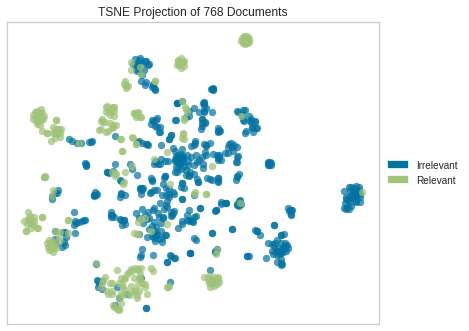

In [0]:
from yellowbrick.text import TSNEVisualizer

tsnse = TSNEVisualizer(size = (600, 400)) # L2 Squared Euclidean Distance
tsnse.fit(docs, labels)
tsnse.poof()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


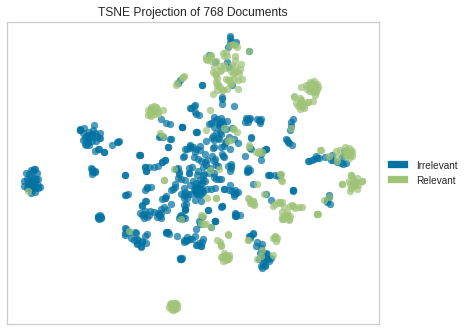

In [0]:
tsnse = TSNEVisualizer(size = (600, 400), metrics = "euclidean") # Euclidean Distance
tsnse.fit(docs, labels)
tsnse.poof()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


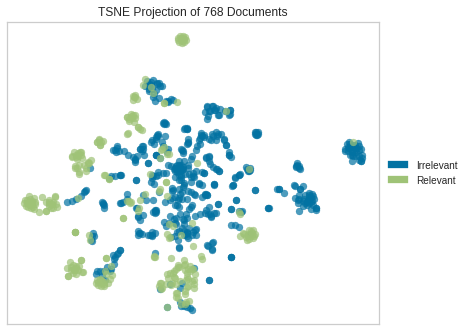

In [0]:
tsne = TSNEVisualizer(size = (600, 400), metrics = "citycub")
tsne.fit(docs, labels)
tsne.poof();

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


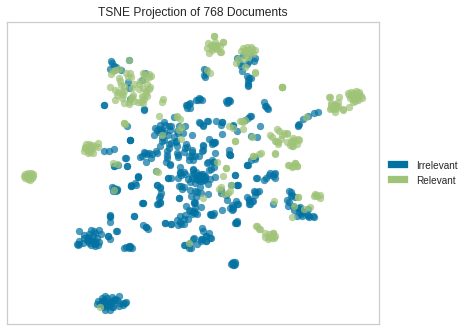

In [0]:
tsne = TSNEVisualizer(size = (600, 400), metrics = "braycurtis")
tsne.fit(docs, labels).poof()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


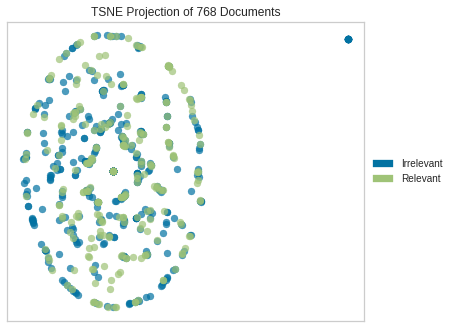

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


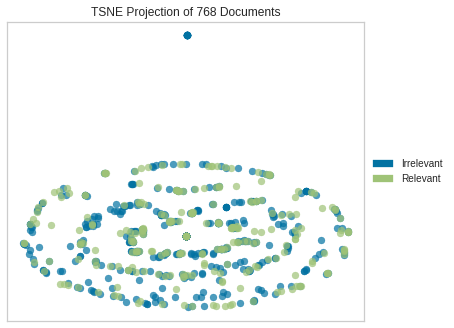

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


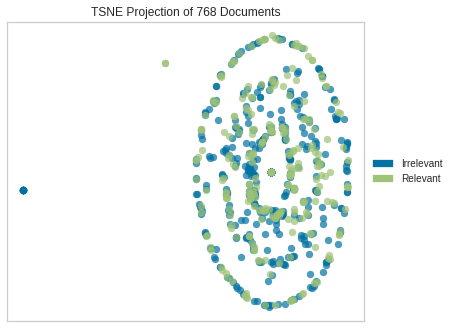

In [0]:
distance_functions = ["sokalmichener", "rogerstanimoto", "hamming"]
for metric in distance_functions:
    tsne = TSNEVisualizer(metric = metric)
    tsne.fit(docs, labels).poof()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

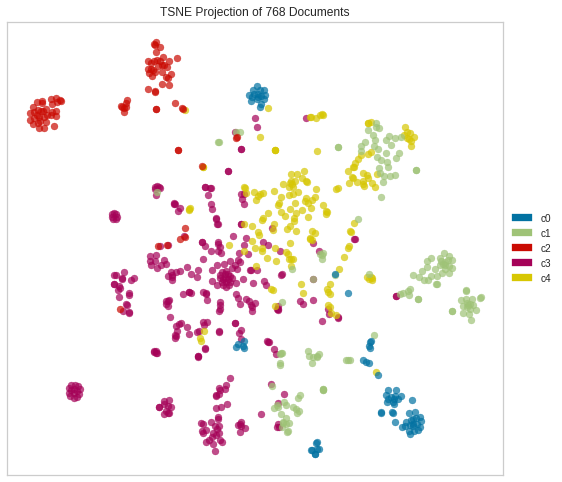

In [0]:
# Apply clustering instead of class names

from sklearn.cluster import KMeans

clusters = KMeans(n_clusters = 5)
clusters.fit(docs)

tsne = TSNEVisualizer(size = (800, 600))
tsne.make_transformer()
tsne.fit(docs, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()